## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [15]:
from keras.datasets import cifar10
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
NUM_CLASSES = 10

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 128

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 25

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'net_final.h5'

# Works 
WORKS = 3

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [18]:
y_train = to_categorical(y_train, NUM_CLASSES)
y_test =  to_categorical(y_test, NUM_CLASSES)

In [19]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)


valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [20]:
# 建立 ResNet 模型
net = resnet(input_shape=x_train.shape[1:]) 
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 32, 32, 16)   64          conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 32, 32, 16)   0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_33 

In [21]:
x = net.output
# x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 32, 32, 16)   64          conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 32, 32, 16)   0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_33 

In [22]:
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = len(x_train)/BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = len(x_test)/BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        verbose=1,
                        workers=WORKS)


Epoch 1/25
391/390 [==============================] - 95s 242ms/step - loss: 2.9013 - acc: 0.1135 - val_loss: 2.8707 - val_acc: 0.1672
Epoch 2/25
391/390 [==============================] - 82s 211ms/step - loss: 2.8562 - acc: 0.1401 - val_loss: 2.8281 - val_acc: 0.2073
Epoch 3/25
391/390 [==============================] - 83s 211ms/step - loss: 2.8265 - acc: 0.1501 - val_loss: 2.8019 - val_acc: 0.2175
Epoch 4/25
391/390 [==============================] - 83s 211ms/step - loss: 2.8082 - acc: 0.1532 - val_loss: 2.7814 - val_acc: 0.22242 - 
Epoch 5/25
391/390 [==============================] - 82s 211ms/step - loss: 2.7915 - acc: 0.1572 - val_loss: 2.7639 - val_acc: 0.2282
Epoch 6/25
391/390 [==============================] - 83s 211ms/step - loss: 2.7758 - acc: 0.1616 - val_loss: 2.7479 - val_acc: 0.2306
Epoch 7/25
391/390 [==============================] - 82s 211ms/step - loss: 2.7594 - acc: 0.1702 - val_loss: 2.7316 - val_acc: 0.2401 
Epoch 8/25
391/390 [==============================

In [23]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

In [24]:
# 評估模型準確率
score = net_final.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.5401354846954347
Test accuracy: 0.3059


Text(0, 0.5, 'Loss')

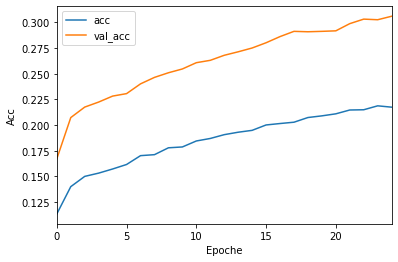

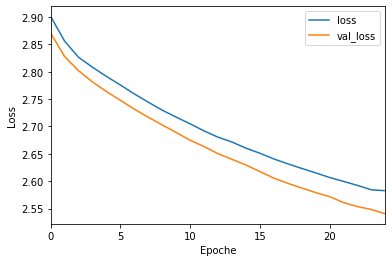

In [42]:
# 訓練歷程
import pandas as pd
%matplotlib inline

df = pd.DataFrame(history.history)
ax1 = df[["acc", "val_acc"]].plot()
ax1.set_xlabel("Epoche")
ax1.set_ylabel("Acc")

ax2 = df[["loss", "val_loss"]].plot()
ax2.set_xlabel("Epoche")
ax2.set_ylabel("Loss")

In [39]:
df

,val_loss,val_acc,loss,acc
0,2.870720,0.1672,2.901354,0.11354
1,2.828084,0.2073,2.856176,0.14008
2,2.801859,0.2175,2.826534,0.15006
3,2.781418,0.2224,2.808179,0.15324
4,2.763870,0.2282,2.791499,0.15726
5,2.747854,0.2306,2.775785,0.16164
6,2.731619,0.2401,2.759454,0.17024
7,2.716827,0.2464,2.744359,0.17120
8,2.702786,0.2509,2.729719,0.17788
9,2.689082,0.2546,2.717036,0.17870
